# Train a deep CNN on XPS data on local machine

In this notebook, we will train a deep convolutional network on iron XPS spectra using the local CPU/GPU.

## Setup

### Install packages

In [1]:
# Imports
import os
import datetime
import pytz
import numpy as np
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Run tensorflow on local CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Load custom modules

In [2]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import network.classifier as classifier
    import network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


## Initial run

### Setting up the parameters & folder structure

In [3]:
np.random.seed(502)
time =  datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_single_4_classes'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.Classifier(time = time,
                         data_name = data_name,
                         labels = label_values)

Model folder created at \saved_models\20200626_14h09m_Fe_single_4_classes
Logs folder created at \logs\20200626_14h09m_Fe_single_4_classes
Figures folder created at \figures\20200626_14h09m_Fe_single_4_classes


### Load and inspect the data

Data was loaded!
Total no. of samples: 1000
No. of training samples: 640
No. of validation samples: 160
No. of test samples: 200
Shape of each sample : 1121 features (X) + 4 labels (y)


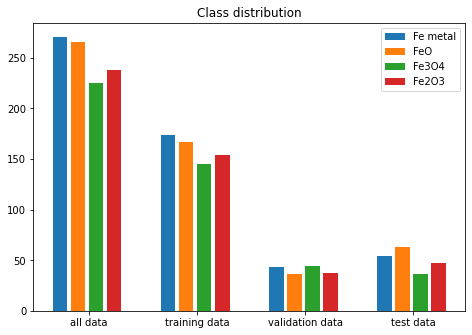

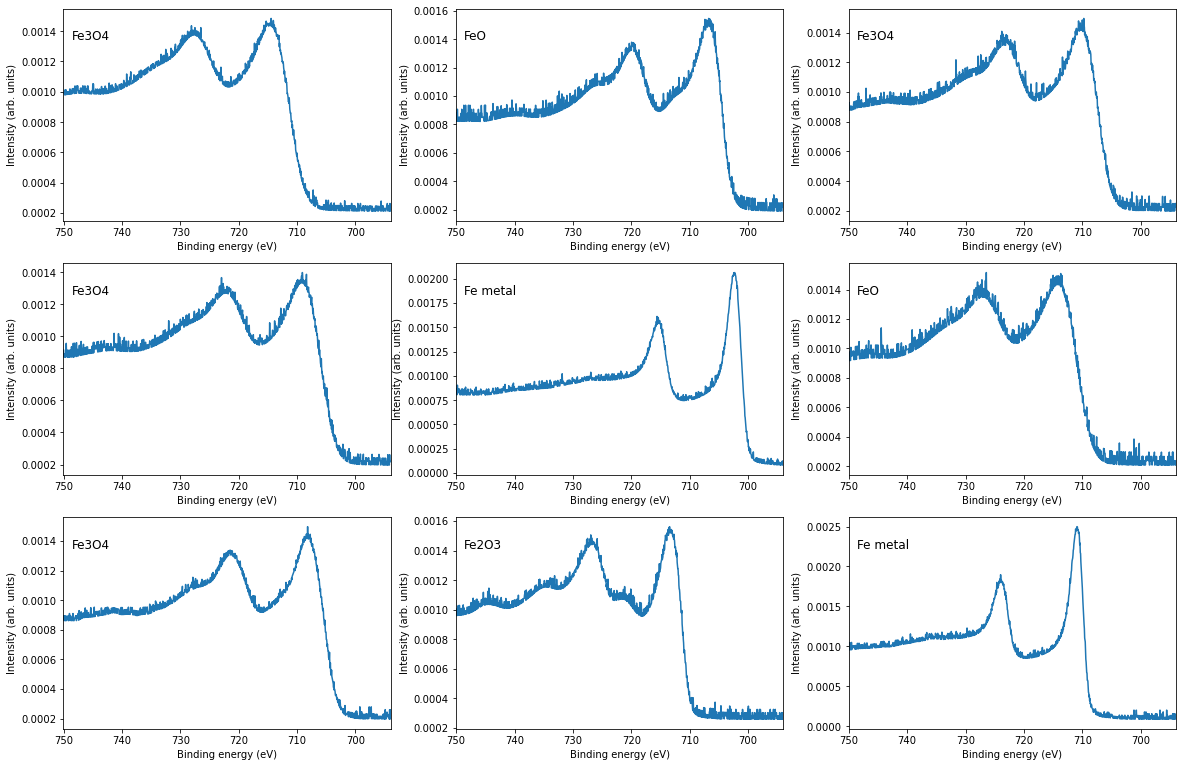

In [4]:
input_filepath = r'C:\Users\pielsticker\Simulations\20200605_iron_single_small.h5'   
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 1000

X_train, X_val, X_test, y_train, y_val, y_test = clf.load_data_preprocess(input_filepath = input_filepath,
                                                                          no_of_examples = no_of_examples,
                                                                          train_test_split = train_test_split,
                                                                          train_val_split = train_val_split)
# Check how the examples are distributed across the classes:
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 9, dataset = 'train')  

### Design the model

In [5]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate
from tensorflow.keras.layers import Conv1D as Convolution1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D
#from tensorflow.keras.layers import BatchNormalization

class CustomCNNSub(Model):
    def __init__(self, inputshape, num_classes, name = None):
        self.inputshape = inputshape
        self.num_classes = num_classes
        
        input_layer = Input(shape = self.inputshape)
                
        conv_short = Convolution1D(4, 5, padding = 'same',
                                 activation = 'relu')(input_layer)
        conv_medium = Convolution1D(4, 10, padding = 'same',
                                    activation = 'relu')(input_layer)
        conv_long = Convolution1D(4, 15, padding = 'same',
                                  activation = 'relu')(input_layer)

        sublayers = [conv_short, conv_medium, conv_long]
        merged_sublayers = concatenate(sublayers)
        
        conv_all = Convolution1D(4, 5, activation='relu')(merged_sublayers)
        pool_all = AveragePooling1D()(conv_all)
        flatten = Flatten()(pool_all)
        drop = Dropout(0.2)(flatten)
        first_dense = Dense(2000, activation = 'relu')(drop)
        output = Dense(self.num_classes, activation = 'softmax')(first_dense)

        super(CustomCNNSub, self).__init__(
            inputs = input_layer,
            outputs = output,
            name = 'Custom_CNN_Sub')
        
        self.no_of_inputs = len(sublayers)
        
    def get_config(self):
        # For serialization with 'custom_objects'
        config = super(CustomCNNSub, self).get_config()
        config['inputshape'] = self.inputshape
        config['num_classes'] = self.num_classes
        config['no_of_inputs'] = self.no_of_inputs
        
        return config

### Build the model

In [7]:
clf.model = CustomCNNSub(clf.input_shape, clf.num_classes)

# Alternative: Build model from available models
# clf.model = models.CustomSimpleCNN(clf.input_shape, clf.num_classes)

### Compile and summarize the model

Model: "Custom_CNN_Sub"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1121, 4)      24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1121, 4)      44          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1121, 4)      64          input_1[0][0]                    
_____________________________________________________________________________________

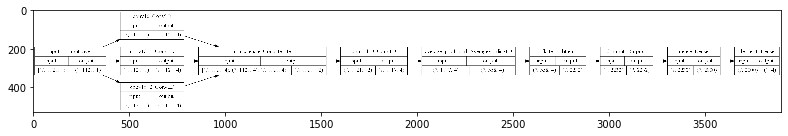

In [8]:
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 


def custom_loss(y_true, y_pred):
    """
    Custom loss for linear combination of XPS spectra.
    """
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

#clf.model.compile(loss = custom_loss, optimizer = 'adam', )

# Alternative: Compile model with build-in loss function
clf.model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer, 
                  metrics = ['accuracy'])


# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Training

In [9]:
epochs = 10
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Train on 640 samples, validate on 160 samples
Epoch 1/10
608/640 [===========================>..] - ETA: 0s - loss: 1.3862 - accuracy: 0.2648WARNING:tensorflow:From C:\Users\pielsticker\Anaconda3\envs\xps\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200626_14h09m_Fe_single_4_classes\assets
640/640 [==============================] - 6s 9ms/sample - loss: 1.3863 - accuracy: 0.2562 - val_loss: 1.3862 - val_accuracy: 0.2688
Epoch 2/10
640/640 [==============================] - 12s 18ms/sample - loss: 1.3860 - accuracy: 0.2891 - val_loss: 1.3862 - val_accuracy: 0.3250
Epoch 3/10
640/640 [============================

### Graphs

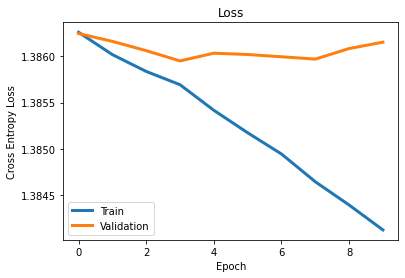

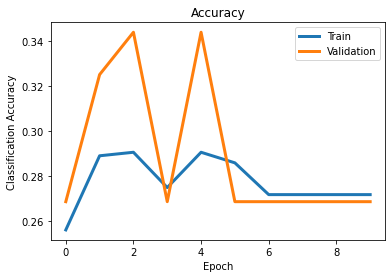

In [10]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name) 

### Evaluation on test data

In [11]:
score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]
print('Test loss: ' + str(np.round(test_loss, decimals=3)))
print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

200/200 [==============================] - 0s 2ms/sample - loss: 1.3811 - accuracy: 0.2700
Evaluation done! 

Test loss: 1.381
Test accuracy: 0.27


### Prediction on test data

In [12]:
pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()

200/200 [==============================] - 1s 4ms/sample
Prediction done!
Class prediction done!


### Show some predictions

#### Training data

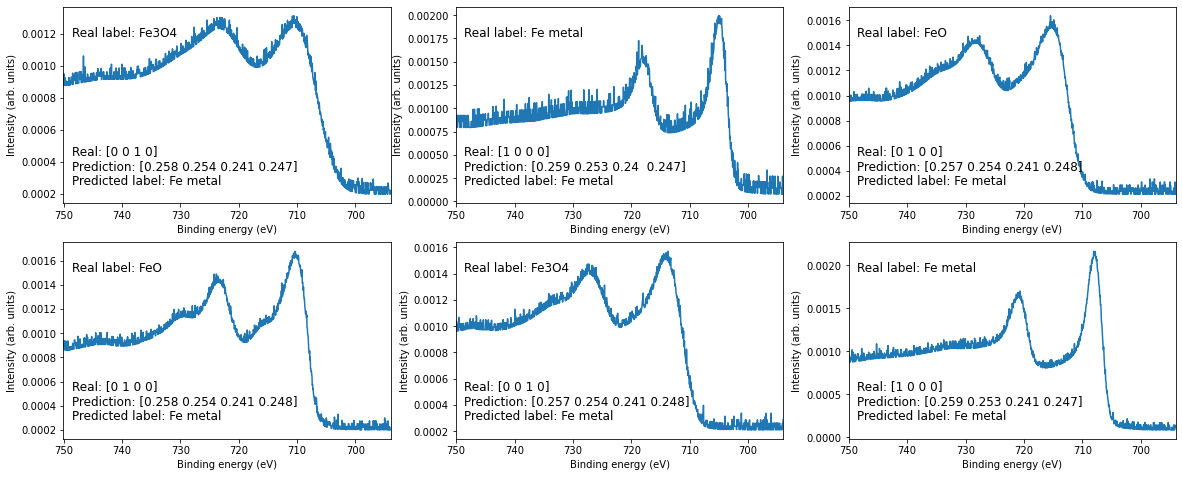

In [13]:
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  

#### Test data

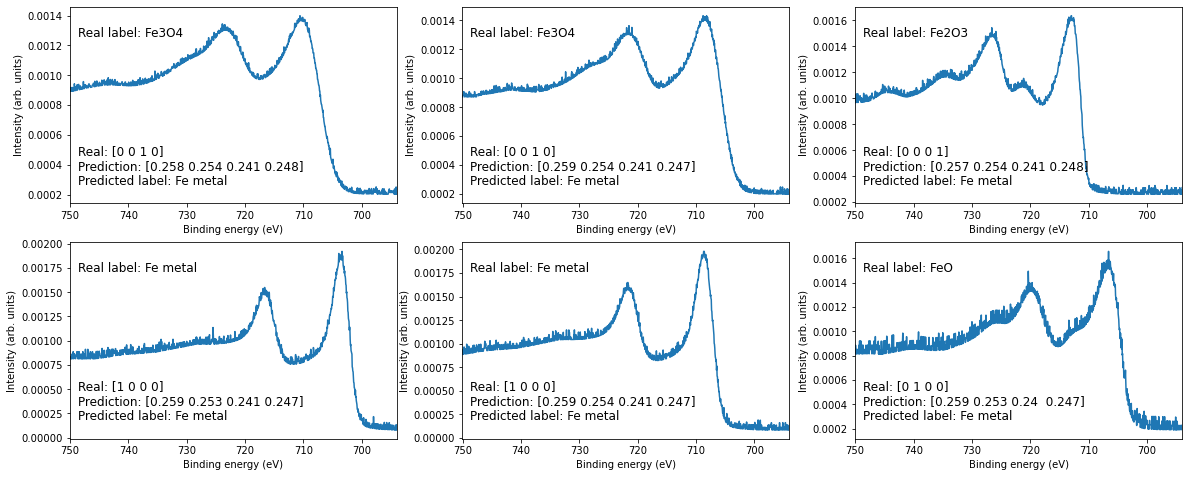

In [14]:
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

### Saving data

In [15]:
clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200626_14h09m_Fe_single_4_classes\assets
Saved model to disk.
Saved hyperparameters to file.
Saved results to file.


### Report

In [16]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

Report saved!


## Continue training 

Loaded model from disk.
New learning rate: 1e-04
Train on 640 samples, validate on 160 samples
Epoch 11/12
640/640 [==============================] - 11s 16ms/sample - loss: 1.3869 - accuracy: 0.2578 - val_loss: 1.3903 - val_accuracy: 0.2688
Epoch 12/12
640/640 [==============================] - 4s 7ms/sample - loss: 1.3834 - accuracy: 0.2719 - val_loss: 1.3844 - val_accuracy: 0.2688
Training done!
New learning rate: 1e-04


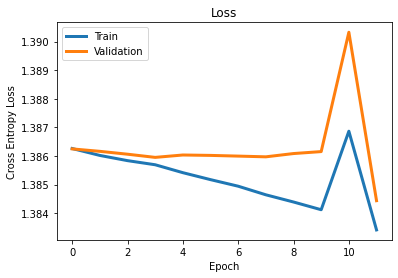

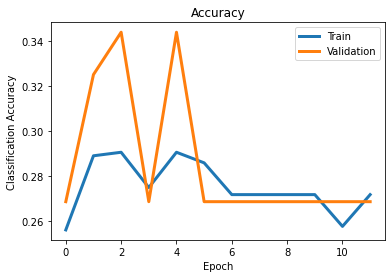

200/200 [==============================] - 0s 2ms/sample - loss: 1.3789 - accuracy: 0.2700
Evaluation done! 

200/200 [==============================] - 0s 1ms/sample
Prediction done!
Class prediction done!
INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200626_14h09m_Fe_single_4_classes\assets
Saved model to disk.
Saved hyperparameters to file.
Saved results to file.
Report saved!


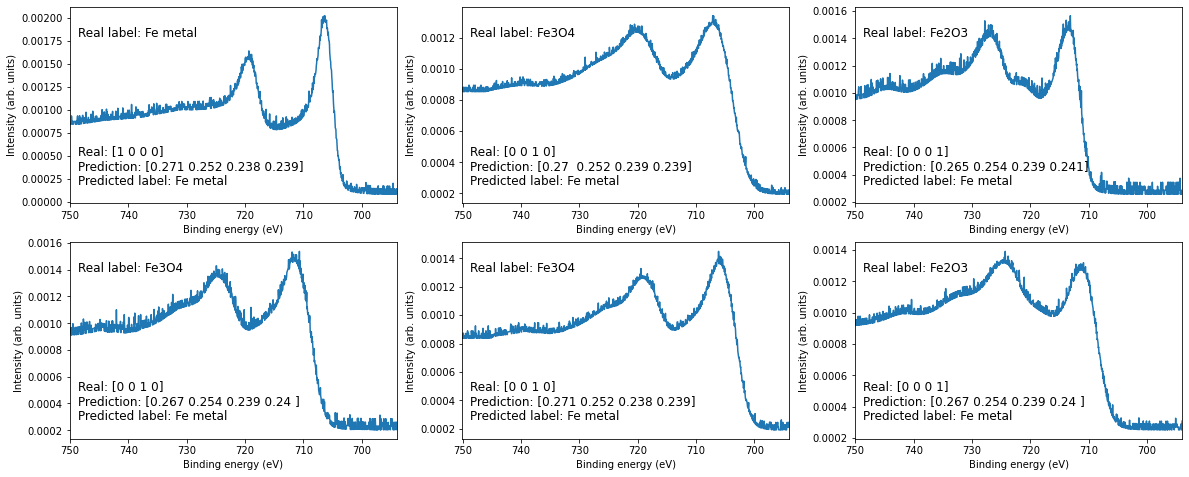

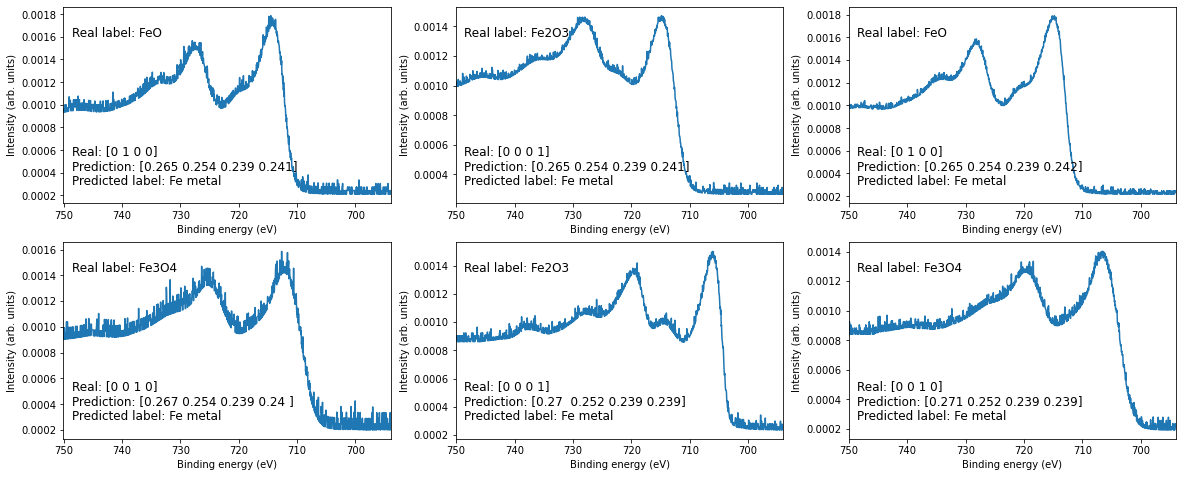

In [17]:
# Reload and train for more epochs
# model_path = r'C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200608_17h51m_Fe_single_4_classes_CNN_simple' 
clf.load_model()
clf.model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer, 
                  metrics = ['accuracy'])

new_learning_rate = 1e-04
epochs = 2
batch_size = 32
hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs,
                 batch_size = batch_size, 
                 new_learning_rate = new_learning_rate) # Learning rate can be changed for retraining

from tensorflow.keras import backend as K
print('New learning rate: ' +\
      str(K.eval(clf.model.optimizer.lr)))

dir_name = clf.time + '_' + clf.data_name
graphs = clfutils.TrainingGraphs(hist, dir_name)

score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]

pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)  

rep = clfutils.Report(dir_name)  
rep.write()  


### Save output of notebook

In [18]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"), include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time

save_notebook()
time.sleep(3)
current_file = 'train_local.ipynb'
output_file = os.path.join(clf.log_dir,'train_local_out.html')
output_HTML(current_file, output_file)